In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from hyperopt import fmin, hp, tpe

In [13]:
labs = pd.read_csv('labs.csv')
exam = pd.read_csv('examination.csv')
demo = pd.read_csv('demographic.csv')
diet = pd.read_csv('diet.csv')
ques = pd.read_csv('questionnaire.csv')

exam.drop(['SEQN'], axis = 1, inplace=True)
demo.drop(['SEQN'], axis = 1, inplace=True)
diet.drop(['SEQN'], axis = 1, inplace=True)
ques.drop(['SEQN'], axis = 1, inplace=True)

df = pd.concat([labs, exam], axis=1, join='inner')
df = pd.concat([df, demo], axis=1, join='inner')
df = pd.concat([df, diet], axis=1, join='inner')
df = pd.concat([df, ques], axis=1, join='inner')

In [14]:
cols = [c for c in df.columns if c[-2:] != 'SI']
df = df[cols]


In [16]:
drop_cols = ['ORXGH', 'ORXGL', 'ORXH06', 'ORXH11', 'ORXH16', 'ORXH18', 'ORXH26', 'ORXH31', 'ORXH33', 'ORXH35', 'ORXH39', 'ORXH40', 'ORXH42', 'ORXH45', 'ORXH51', 'ORXH52', 'ORXH53',
'ORXH54', 'ORXH55', 'ORXH56', 'ORXH58', 'ORXH59', 'ORXH61', 'ORXH62', 'ORXH64', 'ORXH66', 'ORXH67', 'ORXH68', 'ORXH69', 'ORXH70', 'ORXH71', 'ORXH72', 'ORXH73',
             'ORXH81', 'ORXH82', 'ORXH83', 'ORXH84', 'ORXHPC', 'ORXHPI','OHX01TC', 'OHX02TC', 'OHX03TC', 'OHX04TC', 'OHX05TC', 'OHX06TC', 'OHX07TC', 'OHX08TC', 'OHX09TC',
             'OHX10TC', 'OHX11TC', 'OHX12TC', 'OHX13TC', 'OHX14TC', 'OHX15TC', 'OHX16TC', 'OHX17TC', 'OHX18TC', 'OHX19TC', 'OHX20TC', 'OHX21TC', 'OHX22TC', 'OHX23TC', 'OHX24TC',
             'OHX25TC', 'OHX26TC', 'OHX27TC', 'OHX28TC', 'OHX29TC', 'OHX30TC', 'OHX31TC', 'OHX32TC', 'OHX02CTC', 'OHX03CTC', 'OHX04CTC', 'OHX05CTC', 'OHX06CTC', 'OHX07CTC',
             'OHX08CTC', 'OHX09CTC', 'OHX10CTC', 'OHX11CTC', 'OHX12CTC', 'OHX13CTC', 'OHX14CTC', 'OHX15CTC', 'OHX18CTC', 'OHX19CTC', 'OHX20CTC', 'OHX21CTC', 'OHX22CTC',
             'OHX23CTC', 'OHX24CTC', 'OHX25CTC', 'OHX26CTC', 'OHX27CTC', 'OHX28CTC', 'OHX29CTC', 'OHX30CTC', 'OHX31CTC','DMDHRAGE','WTDR2D','WTINT2YR','WTMEC2YR',
             'PHAFSTMN.x','SEQN','RIDSTATR'
            ]
df.drop(drop_cols, axis=1,inplace=True)

In [17]:
col_decoder = {
'ACD011A' : 'speak_english',
'AIALANGA' : 'speak_english2',
'ALQ101' : 'drink_alcohol',
'ALQ130' : 'alcohol_per_day',
'AUQ136' : 'ear_infections',
'BMDAVSAD' : 'saggital_abdominal_avg',
'BMXARMC' : 'arm_circum',
'BMXBMI' : 'BMI',
'BMXLEG' : 'leg_length',
'BMXSAD1' : 'saggital_abdominal_1',
'BMXSAD2' : 'saggital_abdominal_2',
'BMXWAIST' : 'waist_circum',
'BMXWT' : 'weight_kg',
'BPQ020' : 'high_bp',
'BPQ056' : 'measure_bp_home',
'BPQ059' : 'measure_bp_doctor',
'BPQ060' : 'cholesterol_checked',
'BPQ070' : 'cholesterol_checked_1y',
'BPQ080' : 'high_cholesterol',
'BPQ090D' : 'cholesterol_prescription',
'BPXDI1' : 'diastolic_bp',
'BPXML1' : 'cuff_max_inflation',
'BPXSY1' : 'blood_pressure_1',
'BPXSY2' : 'blood_pressure_2',
'BPXSY3' : 'blood_pressure_3',
'CBD070' : 'grocery_budget',
'CBD090' : 'nonfood_budget',
'CBD110' : 'food_budget',
'CBD120' : 'restaurant_budget',
'CBD130' : 'food_delivery_budget',
'CBQ505' : 'fast_food',
'CBQ535' : 'saw_nutrition_fast_food',
'CBQ545' : 'use_nutrition_fast_food',
'CBQ550' : 'eat_restaurants',
'CBQ552' : 'eat_chain_restaurants',
'CBQ580' : 'saw_nutrition_restaurant',
'CBQ590' : 'use_nutrition_restaurant',
'CBQ596' : 'saw_my_plate',
'CDQ001' : 'chest_pain_ever',
'CDQ010' : 'short_breath_stairs',
'CSQ030' : 'sensative_smell',
'CSQ100' : 'loss_of_taste',
'CSQ110' : 'taste_in_mouth',
'CSQ202' : 'dry_mouth',
'CSQ204' : 'nasal_congestion',
'CSQ210' : 'wisdom_teeth_removed',
'CSQ220' : 'tonsils_removed',
'CSQ240' : 'head_injury',
'CSQ250' : 'broken_nose',
'CSQ260' : 'sinus_infections',
'DBD100' : 'salt_frequency',
'DBD895' : 'meals_not_homemade',
'DBD900' : 'meals_fast_food',
'DBD905' : 'meals_prepackaged',
'DBD910' : 'frozen_meals_per_month',
'DBQ095Z' : 'salt_type',
'DBQ197' : 'milk_product_per_month',
'DBQ229' : 'milk_drinker',
'DBQ700' : 'healthy_diet',
'DEQ034C' : 'long_sleeve_shirt',
'DEQ034D' : 'use_sunscreen',
'DEQ038G' : 'sunburn_1y',
'DIQ010' : 'diabetes',
'DIQ050' : 'taking_insulin',
'DIQ160' : 'prediabetes',
'DIQ170' : 'diabetes_risk',
'DIQ172' : 'diabetes_concern',
'DIQ180' : 'blood_test_3y',
'DLQ010' : 'deaf',
'DLQ020' : 'blind',
'DLQ040' : 'mental_issues',
'DLQ050' : 'difficulty_walking',
'DLQ060' : 'difficulty_dressing',
'DLQ080' : 'difficulty_errands',
'DMDBORN4' : 'born_in_us2',
'DMDHHSIZ' : 'people_in_house',
'DMDHHSZB' : 'children_in_house',
'DMDHHSZE' : 'people_over_60_in_house',
'DMDHRBR4' : 'born_in_us',
'DMDHRGND' : 'gender2',
'DMDMARTL' : 'Marital_Status',
'DMDYRSUS' : 'years_in_US',
'DPQ010' : 'no_interest_2w',
'DPQ020' : 'depression',
'DPQ030' : 'trouble_sleeping_2w',
'DPQ040' : 'fatigue_2w',
'DPQ050' : 'eating_problems_2w',
'DPQ060' : 'feel_bad_2w',
'DPQ070' : 'trouble_concentrating_2w',
'DPQ080' : 'speaking_problems_2w',
'DPQ090' : 'suicidal_2w',
'DPQ100' : 'depression_difficulty',
'DR1.320Z' : 'water',
'DR1_320Z' : 'plain_water_yesterday',
'DR1_330Z' : 'tap_water_yesterday',
'DR1BWATZ' : 'bottled_water_yesterday',
'DR1HELPD' : 'interview_help',
'DR1TACAR' : 'dietary_alpha_carotene',
'DR1TALCO' : 'alcohol',
'DR1TATOC' : 'dietary_vitamin_e',
'DR1TBCAR' : 'dietary_beta_carotene',
'DR1TCAFF' : 'caffeine',
'DR1TCALC' : 'dietary_calcium',
'DR1TCARB' : 'carb',
'DR1TCHL' : 'dietary_choline',
'DR1TCHOL' : 'cholesterol',
'DR1TCOPP' : 'dietary_copper',
'DR1TCRYP' : 'dietary_beta_cryptoxanthin',
'DR1TFA' : 'dietary_folic_acid',
'DR1TFF' : 'folate_food',
'DR1TFIBE' : 'fiber',
'DR1TFOLA' : 'dietary_folate',
'DR1TIRON' : 'dietary_iron',
'DR1TKCAL' : 'calories',
'DR1TLYCO' : 'dietary_lycopene',
'DR1TLZ' : 'dietary_lutein',
'DR1TM181' : 'octadecenoic_percent',
'DR1TMAGN' : 'magnesium',
'DR1TMFAT' : 'monounsaturated_fats',
'DR1TMOIS' : 'moisture',
'DR1TNIAC' : 'dietary_niacin',
'DR1TP183' : 'octadecatrienoic_percent',
'DR1TPHOS' : 'dietary_phosphorus',
'DR1TPOTA' : 'dietary_potassium',
'DR1TPROT' : 'protein',
'DR1TRET' : 'dietary_retinol',
'DR1TS140' : 'tetradeconoic_percent',
'DR1TSELE' : 'dietary_selenium',
'DR1TSODI' : 'sodium',
'DR1TSUGR' : 'sugar',
'DR1TTFAT' : 'fat',
'DR1TTHEO' : 'dietary_theobromine',
'DR1TVARA' : 'dietary_vitamin_a',
'DR1TVB1' : 'dietary_b1',
'DR1TVB12' : 'dietary_b12',
'DR1TVB2' : 'dietary_b2',
'DR1TVB6' : 'dietary_b6',
'DR1TVC' : 'dietary_vit_c',
'DR1TVD' : 'dietary_vit_d',
'DR1TVK' : 'dietary_vit_k',
'DR1TZINC' : 'dietary_zinc',
'DRABF' : 'breast_fed',
'DRD340' : 'shellfish',
'DRD350A' : 'clams',
'DRD350B' : 'crabs',
'DRD350C' : 'crayfish',
'DRD350D' : 'lobsters',
'DRD350E' : 'mussels',
'DRD350F' : 'oysters',
'DRD350G' : 'scallops',
'DRD350H' : 'shrimp',
'DRD370A' : 'breaded_fish',
'DRD370B' : 'tuna',
'DRD370C' : 'bass',
'DRD370D' : 'catfish',
'DRD370E' : 'cod',
'DRD370F' : 'flatfish',
'DRD370G' : 'haddock',
'DRD370H' : 'mackerel',
'DRD370I' : 'perch',
'DRD370J' : 'pike',
'DRD370K' : 'pollock',
'DRD370L' : 'porgy',
'DRD370M' : 'salmon',
'DRD370N' : 'sardines',
'DRD370O' : 'sea_bass',
'DRD370P' : 'shark',
'DRD370Q' : 'swordfish',
'DRD370R' : 'trout',
'DRD370S' : 'walleye',
'DRD370T' : 'other_fish',
'DRQSDIET' : 'special_diet',
'DRQSDT1' : 'low_cal_diet',
'DRQSDT10' : 'high_protein_diet',
'DRQSDT11' : 'low_gluten_diet',
'DRQSDT12' : 'kidney_diet',
'DRQSDT2' : 'low_fat_diet',
'DRQSDT3' : 'low_salt_diet',
'DRQSDT4' : 'low_sugar_diet',
'DRQSDT5' : 'low_fiber_diet',
'DRQSDT6' : 'high_fiber_diet',
'DRQSDT7' : 'diabetic_diet',
'DRQSDT8' : 'muscle_diet',
'DRQSDT9' : 'low_carb_diet',
'DRQSDT91' : 'other_diet',
'DRQSPREP' : 'salt_used',
'DUQ200' : 'marijuana',
'DUQ370' : 'needle_drugs',
'FSD032A' : 'food_insecure',
'FSD032B' : 'not_enough_food',
'FSD032C' : 'cheap_food',
'FSD032D' : 'cheap_food_children',
'FSD032E' : 'bad_food_children',
'FSD032F' : 'low_food_children',
'FSD151' : 'emergency_food_received',
'FSDAD' : 'food_secure',
'FSDCH' : 'child_food_secure',
'FSDHH' : 'household_food_secure',
'FSQ162' : 'wic_received',
'FSQ165' : 'food_stamps',
'HEQ010' : 'hepetitis_b',
'HEQ030' : 'hepetitis_c',
'HIQ011' : 'health_insurance',
'HIQ210' : 'insurance_gap',
'HIQ270' : 'prescription_insurance',
'HOD050' : 'rooms_in_home',
'HOQ065' : 'homeowner',
'HSAQUEX' : 'health_status_source_data',
'HSD010' : 'general_health',
'HSQ500' : 'ever_had_cold',
'HSQ510' : 'intestinal_illness',
'HSQ520' : 'ever_had_flu',
'HSQ571' : 'donate_blood',
'HSQ590' : 'hiv',
'HUQ010' : 'general_health2',
'HUQ020' : 'health_compared_last_year',
'HUQ030' : 'routine_healthcare',
'HUQ041' : 'healthcare_location',
'HUQ051' : 'dr_visits',
'HUQ071' : 'overnight_hospital',
'HUQ090' : 'mental_health_treatment',
'IMQ011' : 'hepatitis_a_vaccine',
'IMQ020' : 'hepatitis_b_vaccine',
'IND235' : 'monthly_income',
'INDFMMPC' : 'poverty_level_category',
'INDFMMPI' : 'poverty_level_index',
'INDFMPIR' : 'family_income',
'INQ012' : 'self_employ_income',
'INQ020' : 'income_from_wages',
'INQ030' : 'income_from_SS',
'INQ060' : 'disability_income',
'INQ080' : 'retirement_income',
'INQ090' : 'ss_income',
'INQ132' : 'state_assistance_income',
'INQ140' : 'investment_income',
'INQ150' : 'other_income',
'INQ244' : 'family_savings',
'LBDBCDLC' : 'blood_cadmium',
'LBDBGMLC' : 'methyl_mercury',
'LBDHDD' : 'HDL_mg',
'LBDIHGLC' : 'inorganic_mercury',
'LBDNENO' : 'neutrophils_percent',
'LBDTHGLC' : 'blood_mercury',
'LBDWFL' : 'floride_water',
'LBXEOPCT' : 'eosinophils_percent',
'LBXGH' : 'glyco_hemoglobin',
'LBXLYPCT' : 'lymphocite_percent',
'LBXMC' : 'hemoglobin_concentration',
'LBXSAL' : 'blood_albumin',
'LBXSCA' : 'blood_calcium',
'LBXSGL' : 'serum_glucose_mg',
'LBXSTP' : 'blood_protein',
'MCQ010' : 'asthma_ever',
'MCQ025' : 'asthma_age',
'MCQ035' : 'asthma',
'MCQ040' : 'asthma_year',
'MCQ050' : 'asthma_ER',
'MCQ053' : 'anemia',
'MCQ070' : 'psoriasis',
'MCQ080' : 'overweight',
'MCQ082' : 'celiac_disease',
'MCQ086' : 'gluten_free',
'MCQ092' : 'blood_transfusion',
'MCQ149' : 'menstruate',
'MCQ151' : 'menstruate_age',
'MCQ160A' : 'arthritis',
'MCQ160B' : 'congestive_heart_failure',
'MCQ160C' : 'coronary_heart_disease',
'MCQ160D' : 'angina',
'MCQ160E' : 'heart_attack',
'MCQ160F' : 'stroke',
'MCQ160G' : 'emphysema',
'MCQ160K' : 'bronchitis_ever',
'MCQ160L' : 'liver_condition_ever',
'MCQ160M' : 'thyroid_ever',
'MCQ160N' : 'gout',
'MCQ160O' : 'COPD',
'MCQ170K' : 'bronchitis_now',
'MCQ170L' : 'liver_condition',
'MCQ170M' : 'thyroid_now',
'MCQ180A' : 'arthritis_age',
'MCQ180B' : 'heart_failure_age',
'MCQ180C' : 'heart_disease_age',
'MCQ180D' : 'angina_age',
'MCQ180E' : 'heart_attack_age',
'MCQ180F' : 'stroke_age',
'MCQ180G' : 'emphysema_age',
'MCQ180K' : 'bronchitis_age',
'MCQ180L' : 'liver_condition_age',
'MCQ180M' : 'thyroid_age',
'MCQ180N' : 'gout_age',
'MCQ195' : 'arthritis_type',
'MCQ203' : 'jaundice',
'MCQ206' : 'jaundice_age',
'MCQ220' : 'cancer',
'MCQ230A' : 'cancer_type1',
'MCQ230B' : 'cancer_type2',
'MCQ230C' : 'cancer_type3',
'MCQ230D' : 'cancer_type4',
'MCQ240A' : 'bladder_cancer_age',
'MCQ240AA' : 'test_cancer_age',
'MCQ240B' : 'blood_cancer_age',
'MCQ240BB' : 'thyroid_cancer_age',
'MCQ240C' : 'bone_cancer_age',
'MCQ240CC' : 'uterine_cancer_age',
'MCQ240D' : 'brain_cancer_age',
'MCQ240DK' : 'cancer_age',
'MCQ240E' : 'breast_cancer_age',
'MCQ240F' : 'cervical_cancer_age',
'MCQ240G' : 'colon_cancer_age',
'MCQ240H' : 'esoph_cancer_age',
'MCQ240I' : 'gallbladder_cancer_age',
'MCQ240J' : 'kidney_cancer_age',
'MCQ240K' : 'larynx_cancer_age',
'MCQ240L' : 'leukemia_age',
'MCQ240M' : 'liver_cancer_age',
'MCQ240N' : 'lung_cancer_age',
'MCQ240O' : 'lymphoma_age',
'MCQ240P' : 'melanoma_age',
'MCQ240Q' : 'mouth_cancer_age',
'MCQ240R' : 'nervous_cancer_age',
'MCQ240S' : 'ovarian_cancer_age',
'MCQ240T' : 'pancreatic_cancer_age',
'MCQ240U' : 'prostate_cancer_age',
'MCQ240V' : 'rectal_cancer_age',
'MCQ240X' : 'skin_cancer_age',
'MCQ240Y' : 'soft_cancer_age',
'MCQ240Z' : 'stomach_cancer_age',
'MCQ300A' : 'relative_heart_attack',
'MCQ300B' : 'relative_asthma',
'MCQ300C' : 'relative_diabetes',
'MCQ365A' : 'need_weight_loss',
'MCQ365B' : 'need_exercise',
'MCQ365C' : 'need_reduce_salt',
'MCQ365D' : 'need_reduce_calories',
'MCQ370A' : 'losing_weight',
'MCQ370B' : 'excercising',
'MCQ370C' : 'reducing_salt',
'MCQ370D' : 'reducing_fat',
'MGDCGSZ' : 'grip_strength',
'OCD150' : 'work_done',
'OCD270' : 'months_of_work',
'OCD390G' : 'type_of_work',
'OCD395' : 'job_duration',
'OCQ260' : 'non_govt_employee',
'OHQ030' : 'visit_dentist',
'OHQ033' : 'dentist_reason',
'OHQ620' : 'aching_mouth',
'OHQ640' : 'mouth_problems',
'OHQ680' : 'mouth_problems2',
'OHQ770' : 'need_dental',
'OHQ835' : 'gum_disease',
'OHQ845' : 'teeth_health',
'OHQ850' : 'gum_treatment',
'OHQ855' : 'loose_teeth',
'OHQ860' : 'teeth_bone_loss',
'OHQ865' : 'weird_tooth',
'OHQ870' : 'floss',
'OHQ875' : 'use_mouthwash',
'OHQ880' : 'oral_cancer_exam',
'OHQ885' : 'oral_cancer_exam2',
'OSQ060' : 'osteoporosis',
'OSQ130' : 'take_prednisone',
'OSQ230' : 'metal_objects',
'PAAQUEX' : 'question_source',
'PAD680' : 'sedentary_time',
'PAQ605' : 'vigorous_work',
'PAQ620' : 'moderate_work',
'PAQ635' : 'walk_or_bike',
'PAQ650' : 'vigorous_recreation',
'PAQ665' : 'moderate_recreation',
'PAQ710' : 'tv_hours',
'PAQ715' : 'pc_hours',
'PEASCST1' : 'bp_status',
'PEASCTM1' : 'blood_pressure_time',
'PFQ049' : 'work_limitations',
'PFQ051' : 'work_limitations2',
'PFQ054' : 'walk_equipment_required',
'PFQ057' : 'confusion_memory_problems',
'PFQ090' : 'special_healthcare_equipment',
'PUQ100' : 'insecticide_used',
'PUQ110' : 'weedkiller_used',
'RIAGENDR' : 'gender',
'RIDAGEYR' : 'age',
'RIDRETH1' : 'hispanic',
'RXQ510' : 'take_aspirin',
'SEQN' : 'ID',
'SLD010H' : 'sleep_hours',
'SLQ050' : 'trouble_sleeping',
'SLQ060' : 'sleep_disorder',
'SMAQUEX.x' : 'question_mode',
'SMAQUEX.y' : 'question_mode2',
'SMAQUEX2' : 'question_mode3',
'SMD460' : 'smokers_in_house',
'SMDANY' : 'tobaco_1w',
'SMQ681' : 'smoked_1w',
'SMQ851' : 'tobaco2_1w',
'SMQ856' : 'smoked_at_work',
'SMQ858' : 'someone_smoked_at_job',
'SMQ860' : 'smoked_at_restaurant',
'SMQ863' : 'nicotine_1w',
'SMQ866' : 'smoked_at_bar',
'SMQ870' : 'smoked_in_car',
'SMQ872' : 'someone_smoked_in_car',
'SMQ874' : 'smoked_another_home',
'SMQ876' : 'someone_smoked_in_home',
'SMQ878' : 'smoked_other_building',
'SMQ880' : 'someone_smoked_other_building',
'SXD021' : 'sex_ever',
'URXUCR' : 'creatinine_urine',
'WHD010' : 'height_in',
'WHD020' : 'current_weight_lb',
'WHD050' : 'weight_1y',
'WHD110' : 'weight_10y',
'WHD120' : 'weight_age_25',
'WHD140' : 'greatest_weight',
'WHQ030' : 'overweight_self',
'WHQ040' : 'weightloss_desire',
'WHQ070' : 'weightloss_attempt',
'WHQ150' : 'age_when_heaviest'
}
df = df.rename(columns = col_decoder)
labs = labs.rename(columns = col_decoder)
exam = exam.rename(columns = col_decoder)
demo = demo.rename(columns = col_decoder)
diet = diet.rename(columns = col_decoder)
ques = ques.rename(columns = col_decoder)

In [23]:
cancer_df = df.dropna(subset=['cancer'])
diabetes_df = df.dropna(subset=['diabetes'])
heart_df = df.dropna(subset=['coronary_heart_disease'])
liver_df = df.dropna(subset=['liver_condition'])

In [24]:
target_dfs = [cancer_df, diabetes_df, heart_df, liver_df]

In [25]:
for df in target_dfs:
    df.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,
            777777:None,999999:None,55:None,555:None,5555:None,8:None,88:None}, inplace=True)

<ipython-input-25-8dac1a3039e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,


In [26]:

df.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,
            777777:None,999999:None,55:None,555:None,5555:None,8:None,88:None}, inplace=True)

<ipython-input-26-57e509418585>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({7:None, 9:None, 77:None,99:None,777:None,999:None,7777:None,9999:None,77777:None,99999:None,


In [27]:
def filter_columns(df, cutoff=0.9):
    tot_rows = df.shape[0]
    removed_cols = []
    print("original number of columns: ", df.shape[1])
    for col in df.columns:
        num_na = df[col].isna().sum()
        if (num_na/tot_rows) > cutoff:
            #print(col, df[col].isna().sum())
            removed_cols.append(col)
    print("number of columns removed: ", len(removed_cols))
    return df.drop(removed_cols, axis=1)

def filter_rows(df, cutoff=0.9):
    tot_cols = df.shape[1]
    print("original number of rows: ", df.shape[0])
    df = df[df.isnull().sum(axis=1) < tot_cols*cutoff]
    print("remaining rows: ", df.shape[0])
    return df

In [28]:
def trans_cat_cols(df, cat_cols):
    for col in cat_cols:
        df.loc[df[col] != 1, col] = 0
    return df

In [29]:
x = df.nunique()
cat_cols = x[(x<15)].index
df = trans_cat_cols(df, cat_cols)

<ipython-input-28-412894b9f243>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] != 1, col] = 0


In [30]:
for df in target_dfs:
    x = df.nunique()
    cat_cols = x[(x<15)].index
    df = trans_cat_cols(df, cat_cols)

<ipython-input-28-412894b9f243>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] != 1, col] = 0
<ipython-input-28-412894b9f243>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] != 1, col] = 0
<ipython-input-28-412894b9f243>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] != 1, col] = 0
<ipython-input-28-412894b9f243>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [31]:
for df in target_dfs:
    df = filter_rows(df, cutoff=0.8)
    df = filter_columns(df, cutoff=0.5)

original number of rows:  5561
remaining rows:  5561
original number of columns:  1660
number of columns removed:  259
original number of rows:  9422
remaining rows:  9422
original number of columns:  1660
number of columns removed:  281
original number of rows:  5561
remaining rows:  5561
original number of columns:  1660
number of columns removed:  259
original number of rows:  225
remaining rows:  225
original number of columns:  1660
number of columns removed:  143


In [32]:
for df in target_dfs:
    df.fillna(df.mode().iloc[0], inplace=True)

<ipython-input-32-9087dfee0d3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mode().iloc[0], inplace=True)
<ipython-input-32-9087dfee0d3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mode().iloc[0], inplace=True)
<ipython-input-32-9087dfee0d3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [35]:
df

,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,blood_albumin,LBXSBU,blood_calcium,...,WHD080U,WHD080L,weight_10y,weight_age_25,WHD130,greatest_weight,age_when_heaviest,WHQ030M,WHQ500,WHQ520
46,14.9,14.9,70.0,6188.0,21.29,0.000000,69.0,4.4,22.0,9.5,...,0,0,150.0,190.0,64.0,215.0,35.0,0,0,0
77,29.2,29.2,48.0,4243.2,60.83,96868.192107,69.0,4.0,17.0,9.5,...,0,0,150.0,130.0,69.0,162.0,64.0,0,0,0
86,2.8,2.8,56.0,4950.4,5.00,34938.035435,65.0,4.3,10.0,9.7,...,0,0,170.0,150.0,69.0,175.0,40.0,0,0,0
113,6.6,6.6,172.0,15204.8,3.84,0.000000,69.0,4.9,18.0,10.0,...,0,0,145.0,135.0,64.0,155.0,71.0,0,0,0
184,3.4,3.4,61.0,5392.4,5.57,0.000000,69.0,4.2,14.0,9.6,...,0,0,110.0,95.0,64.0,190.0,34.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9602,6.6,6.6,33.0,2917.2,5.00,0.000000,69.0,4.4,11.0,9.5,...,0,0,165.0,150.0,64.0,215.0,42.0,0,0,0
9608,5.6,5.6,53.0,4685.2,10.57,0.000000,69.0,4.4,11.0,9.5,...,0,0,126.0,108.0,64.0,128.0,47.0,0,0,0
9623,27.8,27.8,336.0,29702.4,8.27,0.000000,69.0,4.7,14.0,9.5,...,0,0,150.0,180.0,64.0,200.0,30.0,0,0,0
9646,3.7,3.7,82.0,7248.8,4.51,54430.038168,57.0,5.0,14.0,10.1,...,0,0,157.0,114.0,64.0,159.0,60.0,0,0,0


In [34]:

# return the column labels
result = df.columns

# Print the result
print(result)

Index(['URXUMA', 'URXUMS', 'URXUCR.x', 'URXCRS', 'URDACT', 'WTSAF2YR.x',
       'LBXAPB', 'blood_albumin', 'LBXSBU', 'blood_calcium',
       ...
       'WHD080U', 'WHD080L', 'weight_10y', 'weight_age_25', 'WHD130',
       'greatest_weight', 'age_when_heaviest', 'WHQ030M', 'WHQ500', 'WHQ520'],
      dtype='object', length=1660)


In [46]:
import pandas as pd
health_columns = [
    'general_health', 'ever_had_cold', 'intestinal_illness', 'ever_had_flu',
    'visit_dentist', 'dentist_reason', 'aching_mouth', 'mouth_problems',
    'mouth_problems2', 'need_dental', 'gum_disease', 'teeth_health',
    'gum_treatment', 'loose_teeth', 'teeth_bone_loss', 'weird_tooth',
    'floss', 'use_mouthwash', 'oral_cancer_exam', 'oral_cancer_exam2',
    'osteoporosis', 'take_prednisone', 'work_limitations',
    'work_limitations2', 'walk_equipment_required',
    'confusion_memory_problems', 'special_healthcare_equipment',
    'insecticide_used', 'weedkiller_used', 'high_bp', 'diabetes',
    'taking_insulin', 'prediabetes', 'diabetes_risk', 'diabetes_concern',
    'cholesterol_checked', 'cholesterol_checked_1y', 'high_cholesterol',
    'cholesterol_prescription'
]


df = df.filter(health_columns)
df

,general_health,ever_had_cold,intestinal_illness,ever_had_flu,visit_dentist,dentist_reason,aching_mouth,mouth_problems,mouth_problems2,need_dental,...,high_bp,diabetes,taking_insulin,prediabetes,diabetes_risk,diabetes_concern,cholesterol_checked,cholesterol_checked_1y,high_cholesterol,cholesterol_prescription
46,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
77,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
113,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9602,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9623,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9646,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [47]:

# return the column labels
result = df.columns

# Print the result
print(result)

Index(['general_health', 'ever_had_cold', 'intestinal_illness', 'ever_had_flu',
       'visit_dentist', 'dentist_reason', 'aching_mouth', 'mouth_problems',
       'mouth_problems2', 'need_dental', 'gum_disease', 'teeth_health',
       'gum_treatment', 'loose_teeth', 'teeth_bone_loss', 'weird_tooth',
       'floss', 'use_mouthwash', 'oral_cancer_exam', 'oral_cancer_exam2',
       'osteoporosis', 'take_prednisone', 'work_limitations',
       'work_limitations2', 'walk_equipment_required',
       'confusion_memory_problems', 'special_healthcare_equipment',
       'insecticide_used', 'weedkiller_used', 'high_bp', 'diabetes',
       'taking_insulin', 'prediabetes', 'diabetes_risk', 'diabetes_concern',
       'cholesterol_checked', 'cholesterol_checked_1y', 'high_cholesterol',
       'cholesterol_prescription'],
      dtype='object')


In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df_health is the DataFrame with the health-related columns

# Extract features (X)
X = df[health_columns]  # Features

# Standardize features (mean=0, variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [52]:
from sklearn.cluster import KMeans

# Number of clusters (you can adjust this based on your needs)
n_clusters = 10

# Fit the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels back to the original DataFrame
df['cluster'] = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [54]:
# Analyze the clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=health_columns)
print('Cluster Centers:')
print(cluster_centers)

# Count the number of samples in each cluster
cluster_counts = df['cluster'].value_counts()
print('Cluster Counts:')
print(cluster_counts)


Cluster Centers:
   general_health  ever_had_cold  intestinal_illness  ever_had_flu  \
0       -0.165521      -0.266798           -0.208699     -0.257586   
1       -0.165521       0.415708           -0.074054      0.156392   
2       -0.165521      -0.172621           -0.160611     -0.183662   
3       -0.165521       0.329798            0.089072      0.220081   
4       -0.165521       0.974122            1.327088      0.259886   
5       -0.165521      -0.093434            0.068510      0.229447   
6       -0.165521      -0.421913           -0.377004     -0.257586   
7        6.041523      -0.421913           -0.377004     -0.257586   
8       -0.165521      -0.149516           -0.081443      0.045324   
9       -0.165521      -0.049637           -0.377004     -0.257586   

   visit_dentist  dentist_reason  aching_mouth  mouth_problems  \
0       0.754630        0.743397     -0.276686       -0.116248   
1      -0.125000        0.697223     -0.276686       -0.116248   
2      -0.1175

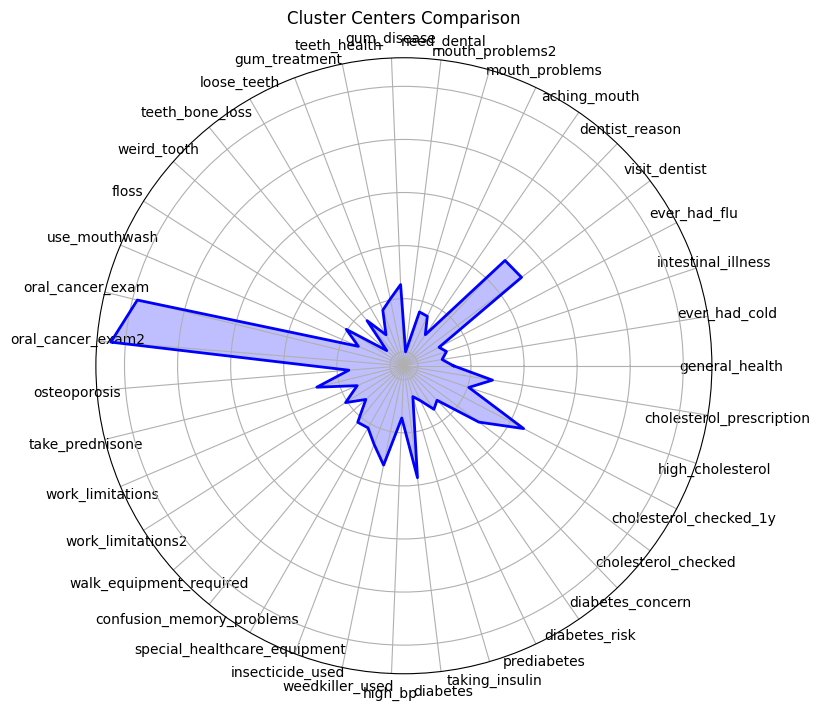

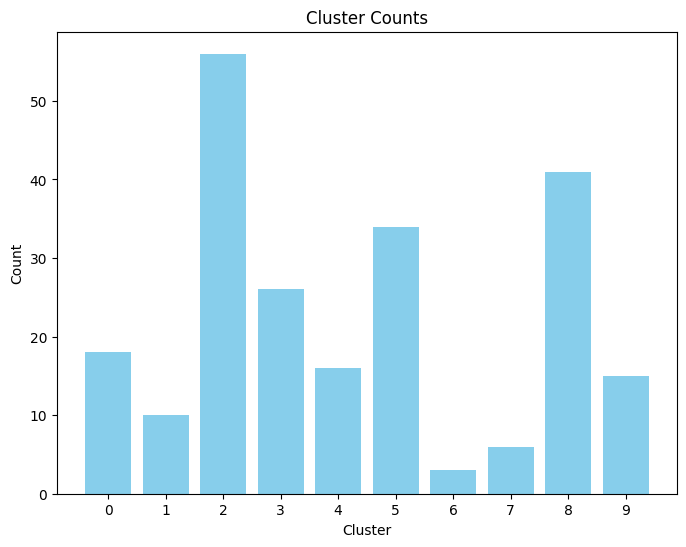

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot radar chart for cluster centers comparison
def plot_radar_chart(cluster_centers):
    attributes = list(cluster_centers)
    values = cluster_centers.iloc[0].values
    values = np.concatenate((values, [values[0]]))  # Close the plot

    angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist()
    angles += angles[:1]  # Close the plot

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='b', alpha=0.25)
    ax.plot(angles, values, color='b', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)
    ax.set_title('Cluster Centers Comparison')
    plt.show()

# Plot the radar chart for cluster centers comparison
plot_radar_chart(cluster_centers)

# Plot bar chart for cluster counts
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Counts')
plt.xticks(range(n_clusters))
plt.show()
